#### **Содержание**
1. Математическая постановка задачи
2. Реализация модели на numpy
3. Проверка работы реализованной модели
4. Сравнение с реализацией в sklearn
5. Сравнение с knn


## **1. Математическая постановка задачи**

Теорема Байеса: 

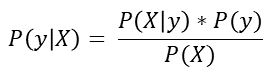

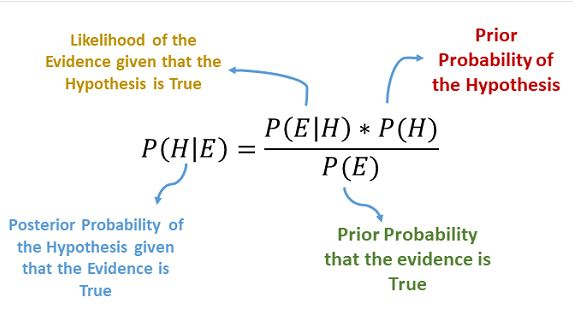

Наивный Байесовский классфикатор - это вероятностная модель, обучающаяся на априорном распределении данных P(X), P(Y) и предсказывающая апостериорное распределение P(Y|X).

Наивный Байес «наивен», потому что предполагает, что характеристики точки данных независимы друг от друга. Это часто неверно для реальных данных, но предположение упрощает расчеты и все же может давать хорошие результаты на практике.

Рассмотрим задачу классификации для K классов: метки классов $y_i \in \{C_1, \ldots, C_k\}$. Теорема Байеса принимает следующую форму

$$
P(y_i = C_k|\mathbf{x}_i) = \frac{P(\mathbf{x}_i|y_i = C_k) P(y_i = C_k)}{P(\mathbf{x}_i)}
$$

Так как мы предполагаем, что признаки независимы, то мы можем представить P(X|Y) в виде произведения:

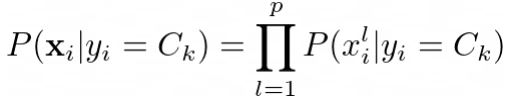

или

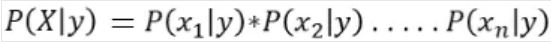

и получаем

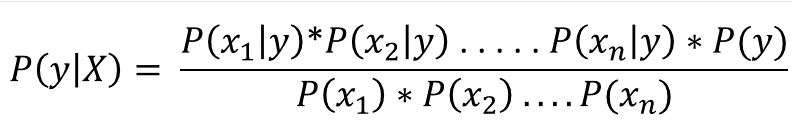

Тогда наша задача сводится к:

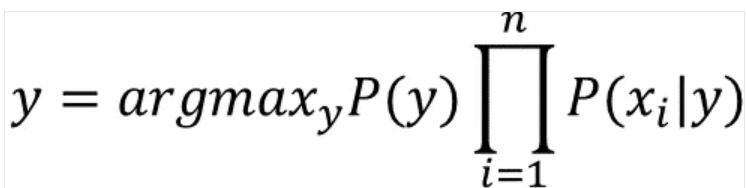

Одно общее правило — выбирать наиболее вероятную гипотезу; Оно известно как максимальное апостериорное правило или правило принятия решения MAP.



Однако произведение - слишком дорогое для вычисления удовольствие. Благо, мы знаем, что логарифмировав P(X|Y) мы сможем представить это произведение в виде суммы логарифмов его множителей. В таком случае задача сводится к:

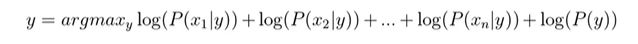


Напомню термины и дам им прикладное объяснение (как считать):

1) **P(Y)**  - В нашей задаче это априорная вероятность (априорное распределение). Для каждого класса - это частота класса по всей обучающей выборке. 
2) **P($x_{i}$ | y)** - распределение объектов для класса. То есть для класса 0 у нас одна плотность распределения $w(x)$. Для класса 1 - другая. 
Мы можем априорно дать оценку этому распределению. Обычно в качестве предположения берут распределение Гаусса и радуются. 
Однако в реальности данные далеки от нормального распределения. К счастью, распределения можно посчитать для каждого признака по отдельности (из-за условия наивности). Построить гистограммы и работать с ними. Здесь я ограничусь нормальным распределением. Однако в [документации sklearn](https://scikit-learn.org/stable/modules/naive_bayes.html) можно почитать, как другие распределения встраиваются в классификатор наивного Байеса
3) **P(y|X)** - апостериорная вероятность. То - есть наше предсказание, насколько вернятно, что объект принадлежит к классу i

Формула нормального распределения:

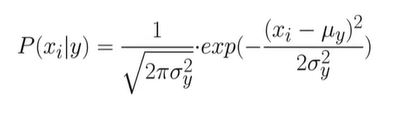

В итоге наши шаги следующие:

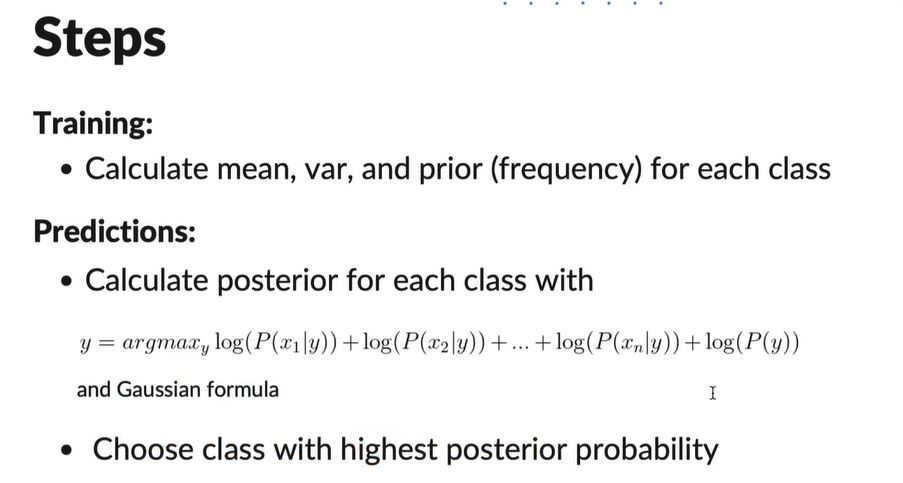

## **2. Реализация модели на numpy**

In [134]:
import numpy as np

In [135]:
class CoolNaiveBayes:

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)

        #Для каждого класса по каждому объекту этого класса посчитаем параметры нормального распределения (математическое ожтдание и дисперсию) по каждому признаку
        self._mean = np.zeros((n_classes, n_features), dtype = np.float64)
        self._var = np.zeros((n_classes, n_features), dtype = np.float64)
        self._priors = np.zeros(n_classes, dtype = np.float64)

        for id, c in enumerate(self._classes):
            X_c = X[y == c]
            self._mean[id, :] = X_c.mean(axis = 0)
            self._var[id, :] = X_c.var(axis = 0)
            self._priors[id] = X_c.shape[0]/float(n_samples)
        
    def _pdf(self, class_idx, x):
        mean = self._mean[class_idx]
        var = self._var[class_idx]
        numer = np.exp(-((x-mean)**2)/(2*var)) 
        den = np.sqrt(2*np.pi*var)
        return numer/den
    
    def _pred(self, x):
        posteriors = []

        for id, c in enumerate(self._classes):
            prior = np.log(self._priors[id])
            posterior = np.sum(np.log(self._pdf(id, x)))
            posteriors.append(posterior + prior)

        return self._classes[np.argmax(posteriors)]
    
    def predict(self, X):
        y_pred = [self._pred(x) for x in X]
        return np.array(y_pred)

## **3. Проверка реализации**

In [136]:
from sklearn.metrics import accuracy_score
def fit_predict(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    return accuracy_score(y_test, model.predict(X_test))

In [137]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [138]:
df = pd.read_csv('../Datasets/Classification/train.csv')
X = df.drop(columns="price_range")
# X = df.drop(columns="Unnamed: 0")
y = df["price_range"]

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [140]:
X_tr_np = np.array(X_train)
X_tst_np = np.array(X_test)
y_tr_np = np.array(y_train)
y_tst_np = np.array(y_test)

In [141]:
nb = CoolNaiveBayes()

In [142]:
print(fit_predict(nb, X_tr_np, X_tst_np, y_tr_np, y_tst_np))

0.7916666666666666


## **4. Сравнение реализации с реализацией из sklearn**

In [149]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [150]:
sk_nb = GaussianNB()
knn = KNeighborsClassifier()

In [151]:
print(fit_predict(sk_nb, X_tr_np, X_tst_np, y_tr_np, y_tst_np))


0.7916666666666666


In [152]:
print(fit_predict(knn, X_tr_np, X_tst_np, y_tr_np, y_tst_np))

0.9166666666666666


Качетсво sklearn абсолютно совпадает с нашим

Однако можно заметить, что KNN показывает намного более лучший результат. Конечно, Наивный Байес на то и наивный, что живет в идеальном мире Гауссовского распределения. У него гладко всё на бумаге, да забыл он про овраги. 

Простой и брутальный KNN более жизнеспособен и прост. 